In [1]:
import sys, os
sys.path.append(os.path.abspath(
    os.getcwd()+"/core")
)

In [2]:
from core.neural_network import load_params
from core.quantum_error_correction_code import deformation_cmap, SurfaceCode

import matplotlib.pyplot as plt
import jax.numpy as jnp

Unique samples: 425


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


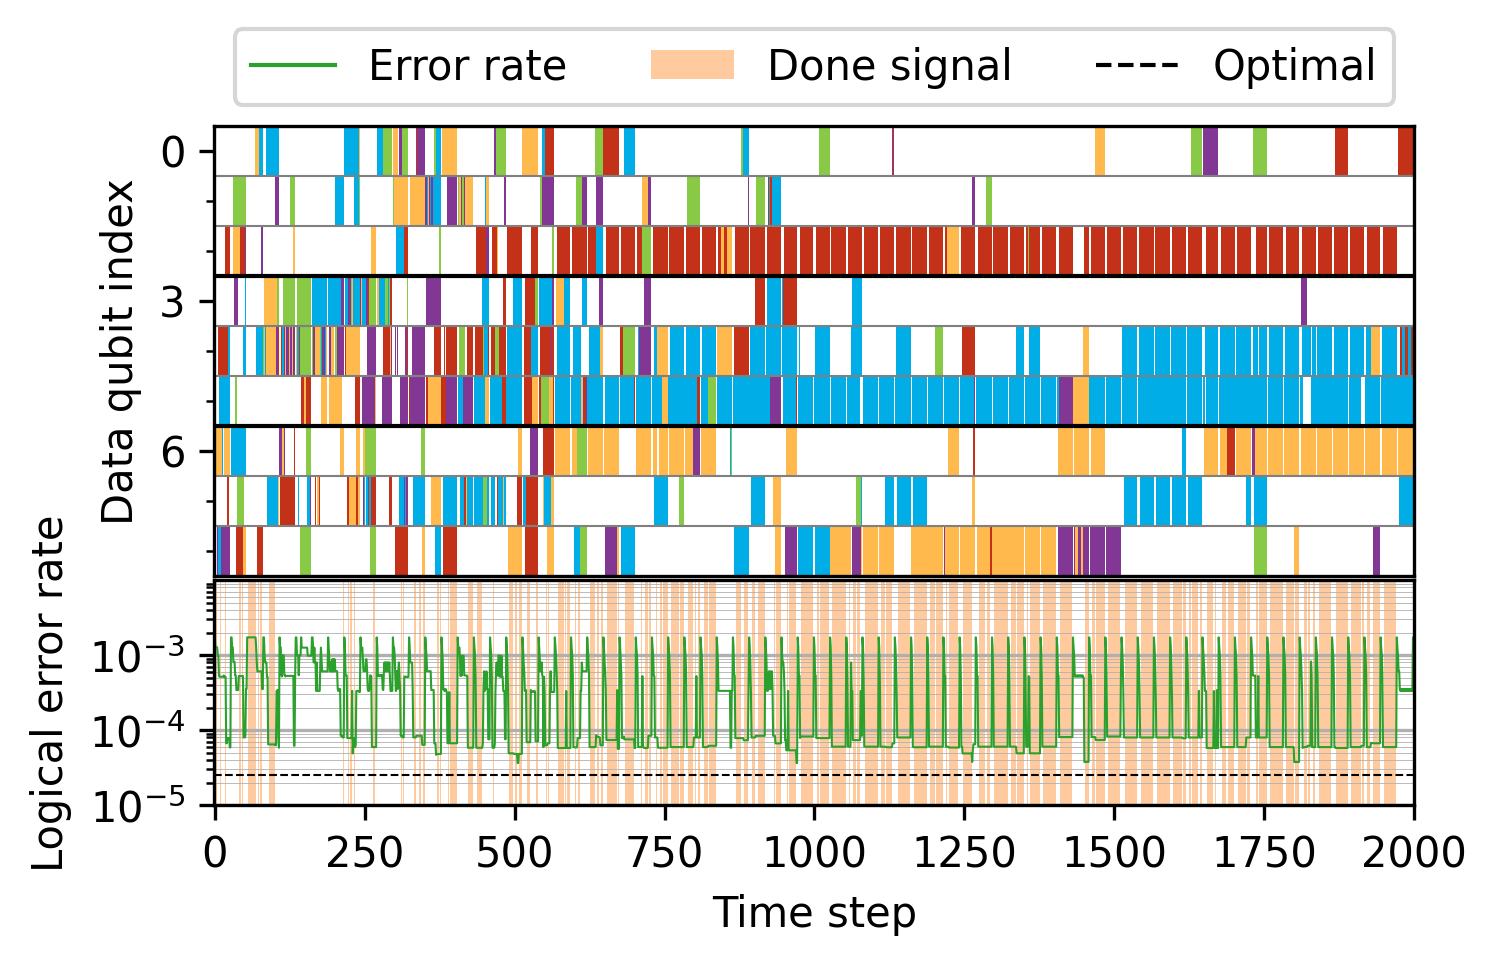

Unique samples: 593


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


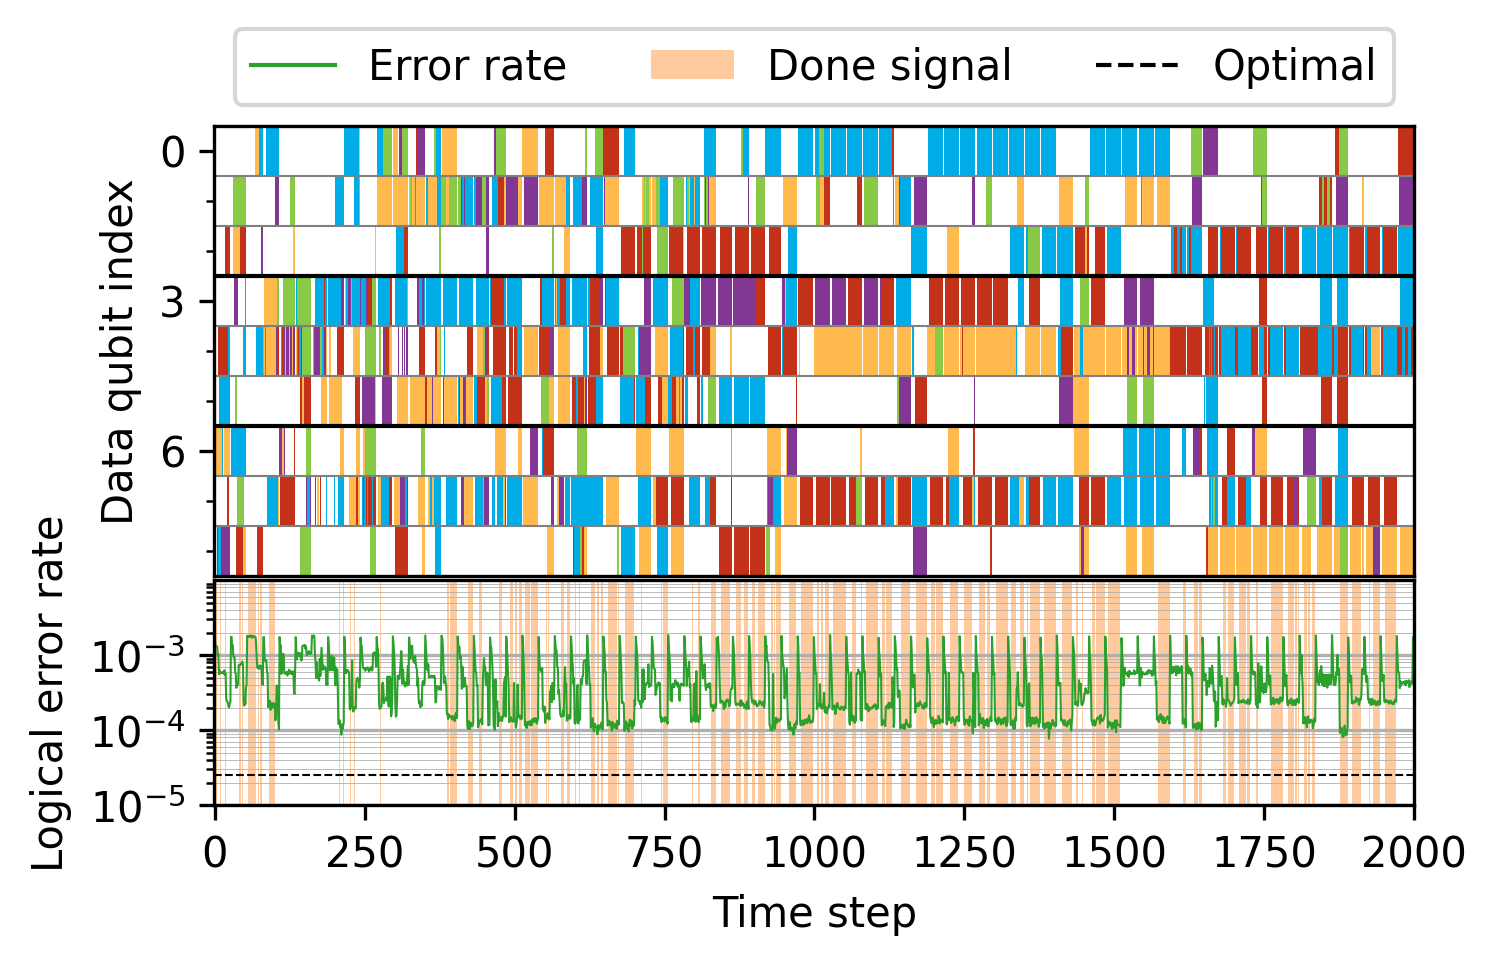

Unique samples: 662


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


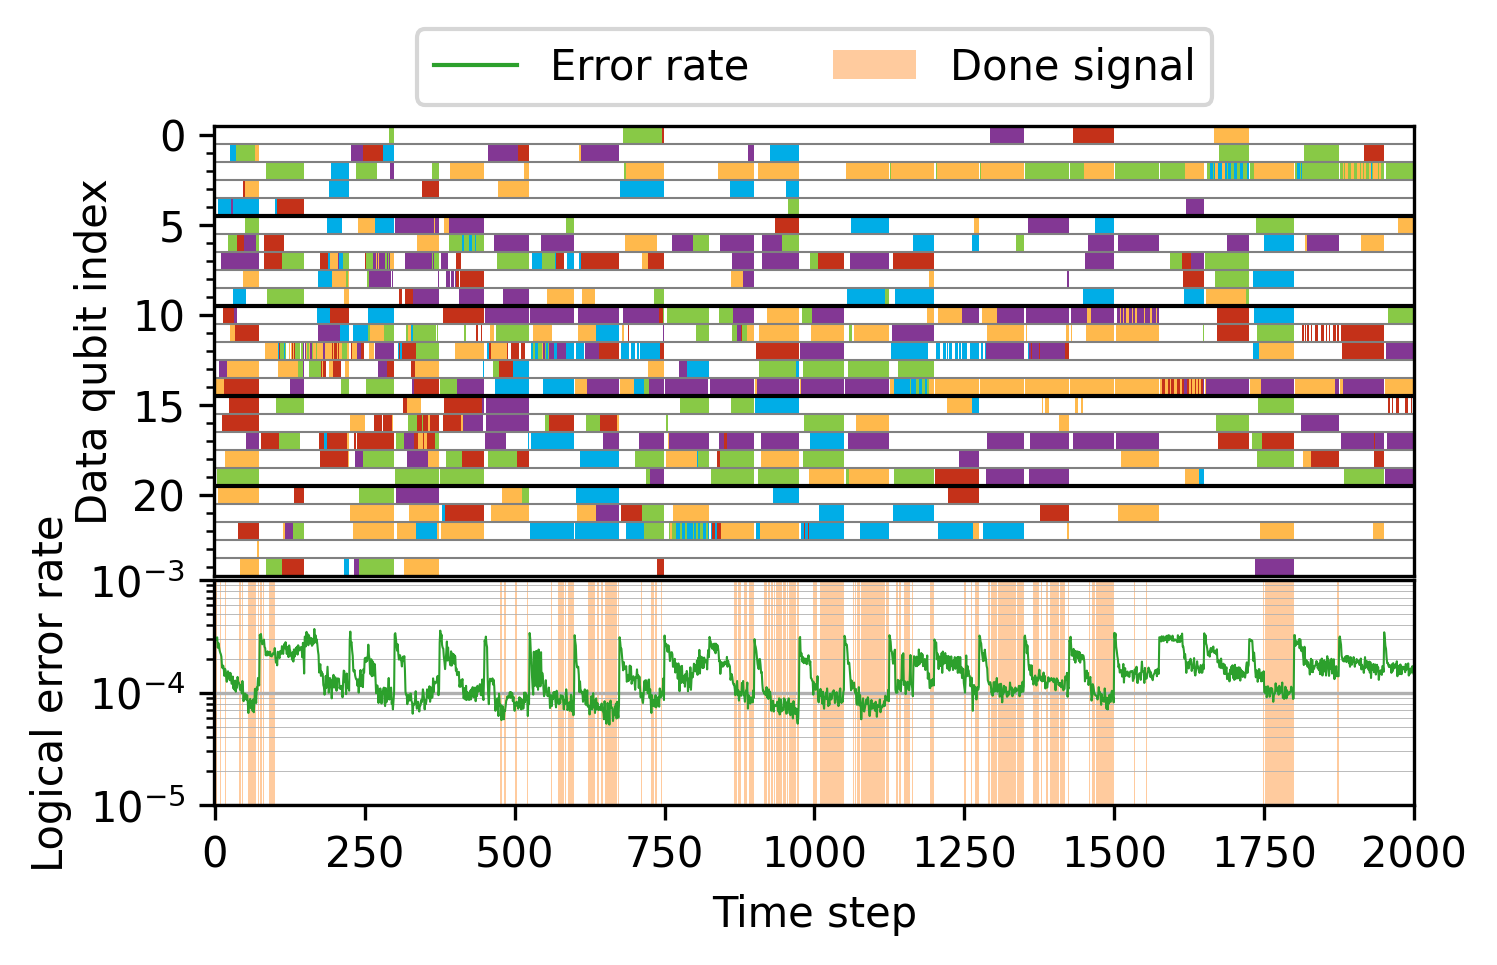

Unique samples: 747


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


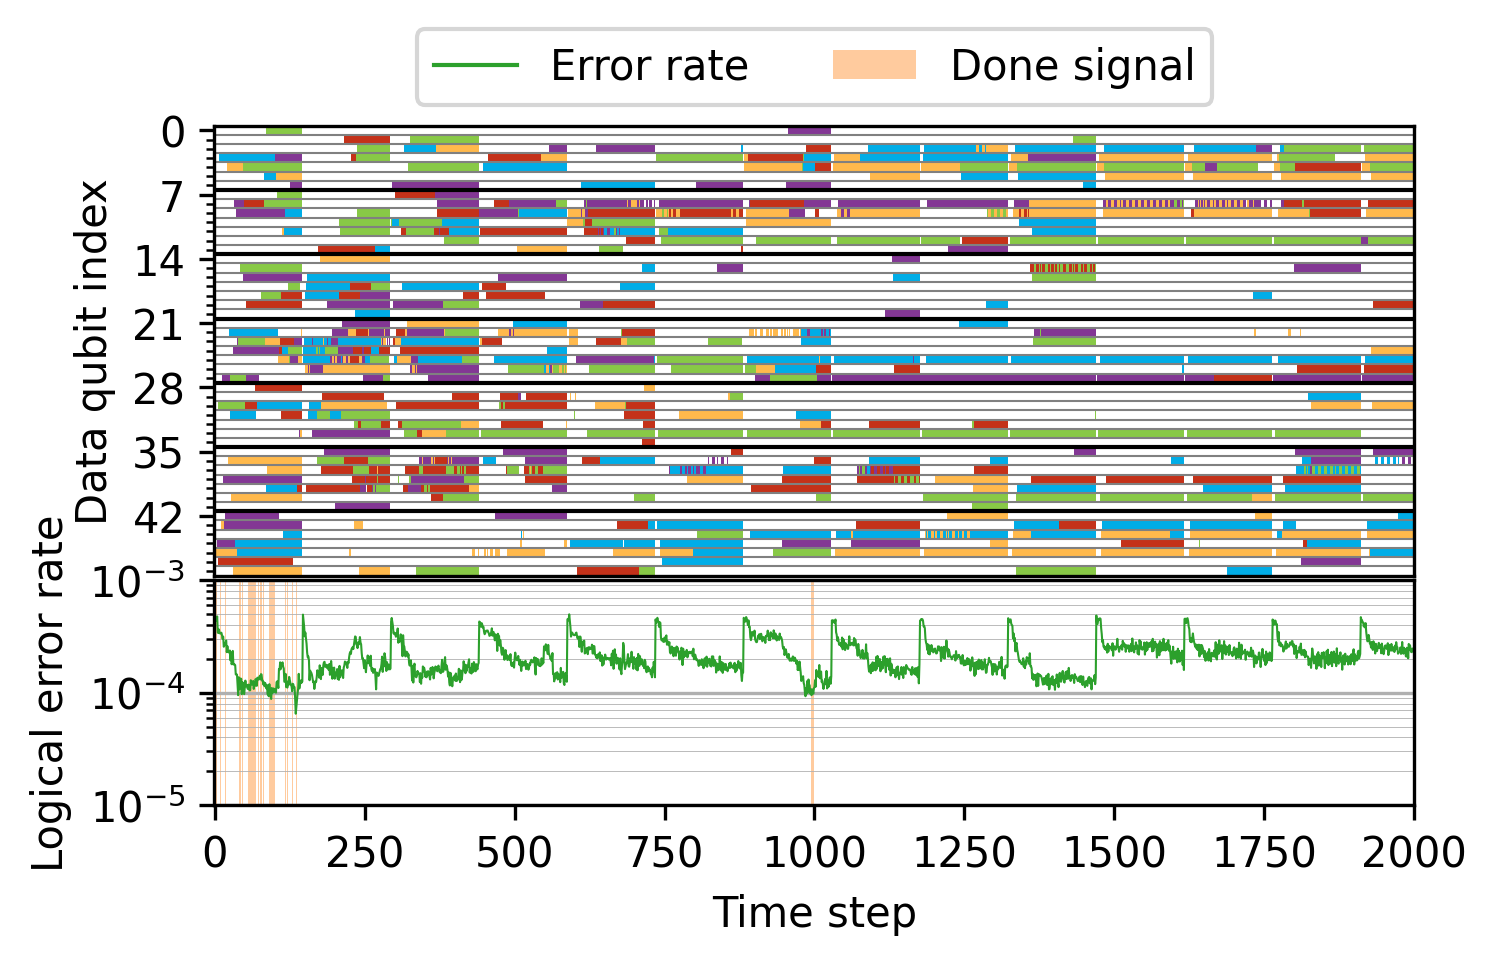

In [116]:
for decoder_type, code_distance in zip(["PML", "CNN-G", "CNN-G", "CNN-G"], [3, 3, 5, 7]):
    settings, model_params = load_params(f"data/RL-{decoder_type}-{code_distance}-decay_with_periodic-reset.json")

    settings.keys()

    deformations = settings["deformations"]
    losses = settings["losses"]
    scores = settings["scores"]
    error_rates = -jnp.log10(.99) / scores
    dones = settings["dones"]

    TRAINING_BATCHES = settings["TRAINING_BATCHES"]
    CODE_DISTANCE = code_distance
    EPISODE_LENGTH = 3*CODE_DISTANCE**2

    print(f"Unique samples: {jnp.unique(deformations, axis=0).shape[0]}")

    # Log avarage error rate
    running_avg_error_rate = jnp.exp(jnp.convolve(jnp.log(error_rates), jnp.ones(2*EPISODE_LENGTH)/EPISODE_LENGTH/2, mode='valid'))

    fig = plt.figure(dpi=300, figsize=(4,1.5))

    im_aspect = TRAINING_BATCHES / deformations.shape[1]
    fig_aspect = fig.get_figheight() / fig.get_figwidth()

    ax = fig.add_axes((0,0,1,1))
    im = ax.imshow(deformations.T, aspect=im_aspect*fig_aspect, interpolation="nearest", cmap=deformation_cmap, vmin=-.5, vmax=5.5)
    ax.set_ylabel("Data qubit index")
    ax.set_xlim(-.5, TRAINING_BATCHES+.5)
    ax.set_xticks([])
    ax.set_yticks(jnp.arange(0, deformations.shape[1], CODE_DISTANCE))
    ax.set_yticks(jnp.arange(0, deformations.shape[1]), minor=True)
    ax.set_yticklabels(jnp.arange(0, deformations.shape[1], CODE_DISTANCE))
    ax.hlines(jnp.arange(CODE_DISTANCE**2)[1:]-.5, [-1]*(CODE_DISTANCE**2-1), [error_rates.shape[0]]*(CODE_DISTANCE**2-1), color='gray', lw=.5)
    ax.hlines(CODE_DISTANCE*jnp.arange(CODE_DISTANCE)[1:]-.5, [-1]*(CODE_DISTANCE-1), [error_rates.shape[0]]*(CODE_DISTANCE-1), color='k', lw=1)
    # for i in range(0, TRAINING_BATCHES, EPISODE_LENGTH):
    #     ax.axvline(i, color='blue', linestyle='--', lw=0.5)

    ax = fig.add_axes((0,-.51,1,.5))
    ax.plot(range(error_rates.shape[0]), error_rates, '-', c='C2', lw=.5, ms=2, label='Error rate')
    # ax.plot(jnp.arange(len(running_avg_error_rate))+EPISODE_LENGTH, running_avg_error_rate, 'r--', lw=.5, label='Running Avg')
    ax.set_xlim(-.5, error_rates.shape[0]+.5)
    ax.set_yscale('log')
    ax.set_ylim(10**jnp.floor(jnp.log10(error_rates.min())), 10**jnp.ceil(jnp.log10(error_rates.max())))
    ax.set_ylabel("Logical error rate")
    ax.grid(which='major', axis='y')
    ax.grid(which='minor', lw=.2)
    ax.set_xlabel("Time step")
    ax.fill_between(
        range(error_rates.shape[0]),
        10**jnp.floor(jnp.log10(error_rates.min()))*jnp.ones(error_rates.shape[0]),
        10**jnp.ceil(jnp.log10(error_rates.max()))*jnp.ones(error_rates.shape[0]),
        color='C1', alpha=.4,
        where=dones, lw=0,
        label='Done signal',
    )
    # for i in range(0, TRAINING_BATCHES, EPISODE_LENGTH):
    #     ax.axvline(i, color='blue', linestyle='--', lw=0.5)

    if code_distance == 3:
        ax.axhline(y=2.5E-5, color='k', linestyle='--', lw=.5, label='Optimal')
    handles, labels = ax.get_legend_handles_labels()
    leg = fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1))

    # change the line width for the legend
    for line in leg.get_lines():
        line.set_linewidth(1)

    plt.savefig(f"figs/RL-{decoder_type}-{code_distance}-results.eps", dpi=300, bbox_inches='tight')
    plt.savefig(f"figs/RL-{decoder_type}-{code_distance}-results.pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"figs/RL-{decoder_type}-{code_distance}-results.png", dpi=300, bbox_inches='tight')

    plt.show()

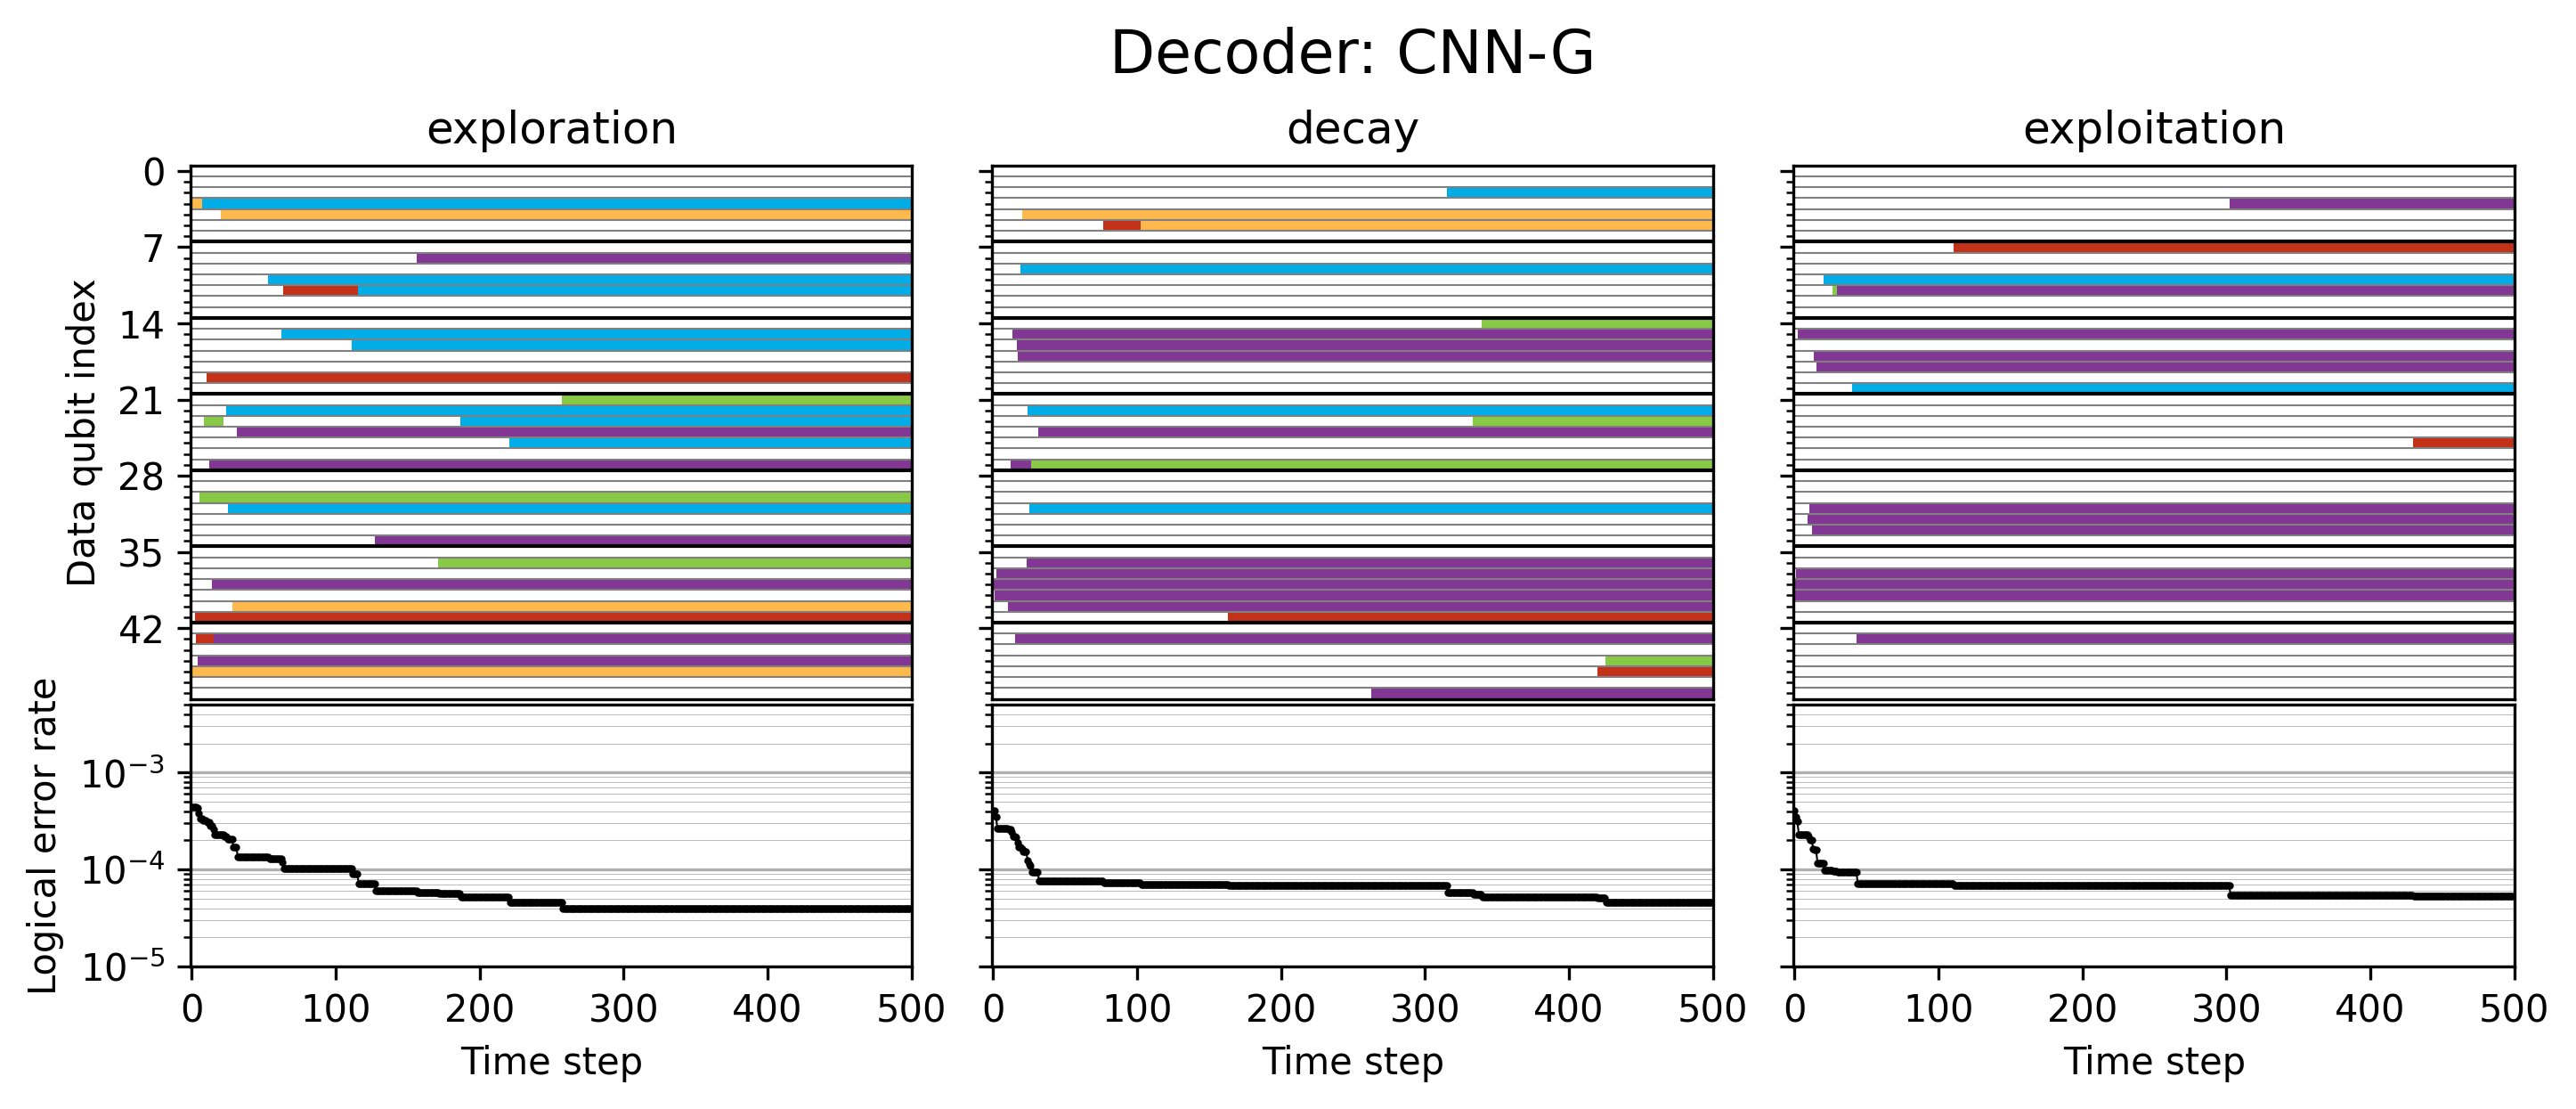

In [5]:
CODE_DISTANCE = 7
ENVIRONMENT_TYPE = "CNN-G"

scaling_names = ["exploration", "decay", "exploitation"]

fig = plt.figure(dpi=300, figsize=(3,2))

xlim = (-.5, 500+.5)
ylim = (1E-5, 5E-3)

for i, scaling_name in enumerate(scaling_names):
    settings, model_params = load_params(f"data/RL-{ENVIRONMENT_TYPE}-{CODE_DISTANCE}-{scaling_name}.json")

    scores = settings["scores"]
    deformations = settings["deformations"]
    dones = settings["dones"]

    error_rates: jnp.ndarray = -jnp.log(.99) / scores[:1+int(xlim[-1]-.5)]
    # error_rates: jnp.ndarray = -jnp.log(.99) / scores#[~dones]

    width = .9
    ax1 = fig.add_axes((i,0,width,1))
    ax2 = fig.add_axes((i,-.5,width,.49))

    ax1.set_title(scaling_name)

    im_aspect = error_rates.shape[0] / deformations.shape[1]
    fig_aspect = fig.get_figheight() / fig.get_figwidth() / width

    im = ax1.imshow(deformations[:error_rates.shape[0]].T, aspect=im_aspect*fig_aspect, interpolation="nearest", cmap=deformation_cmap, vmin=-.5, vmax=5.5)
    ax1.set_xlim(*xlim)
    ax1.set_xticks([])
    ax1.set_yticks(jnp.arange(0, deformations.shape[1], CODE_DISTANCE))
    ax1.set_yticks(jnp.arange(0, deformations.shape[1]), minor=True)
    ax1.set_yticklabels(jnp.arange(0, deformations.shape[1], CODE_DISTANCE))
    ax1.hlines(jnp.arange(CODE_DISTANCE**2)[1:]-.5, [-1]*(CODE_DISTANCE**2-1), [error_rates.shape[0]]*(CODE_DISTANCE**2-1), color='gray', lw=.5)
    ax1.hlines(CODE_DISTANCE*jnp.arange(CODE_DISTANCE)[1:]-.5, [-1]*(CODE_DISTANCE-1), [error_rates.shape[0]]*(CODE_DISTANCE-1), color='k', lw=1)
    ax1.fill_between(
        range(len(dones)), 
        -0.5, 
        deformations.shape[1] - 0.5, 
        where=dones, 
        color='gray', 
        alpha=0.5, 
        step='mid'
    )

    ax2.plot(range(error_rates.shape[0]), error_rates, '.-k', lw=.5, ms=2)
    ax2.set_xticks(jnp.arange(0, 550, 100))
    ax2.set_xlim(-.5, error_rates.shape[0]+.5)
    ax2.set_yscale('log')
    ax2.set_ylim(*ylim)
    ax2.set_xlim(*xlim)
    ax2.grid(which='major', axis='y')
    ax2.grid(which='minor', lw=.2)
    ax2.set_xlabel("Time step")

    if i != 0:
        ax1.set_yticklabels([], minor=False)
        ax1.set_yticklabels([], minor=True)
        ax2.set_yticklabels([], minor=False)
        ax2.set_yticklabels([], minor=True)
    else:
        ax1.set_ylabel("Data qubit index")
        ax2.set_ylabel("Logical error rate")
    
    if i == 1:
        ax1.annotate(
            f"Decoder: {ENVIRONMENT_TYPE}",
            xy=(.5, 1.15),
            xycoords="axes fraction",
            ha="center",
            va="bottom",
            fontsize=16,
        )

# plt.savefig(f"figs/RL-Progress-{ENVIRONMENT_TYPE}-{CODE_DISTANCE}.eps", bbox_inches='tight', dpi=300)
# plt.savefig(f"figs/RL-Progress-{ENVIRONMENT_TYPE}-{CODE_DISTANCE}.pdf", bbox_inches='tight', dpi=300)
# plt.savefig(f"figs/RL-Progress-{ENVIRONMENT_TYPE}-{CODE_DISTANCE}.png", bbox_inches='tight', dpi=300)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


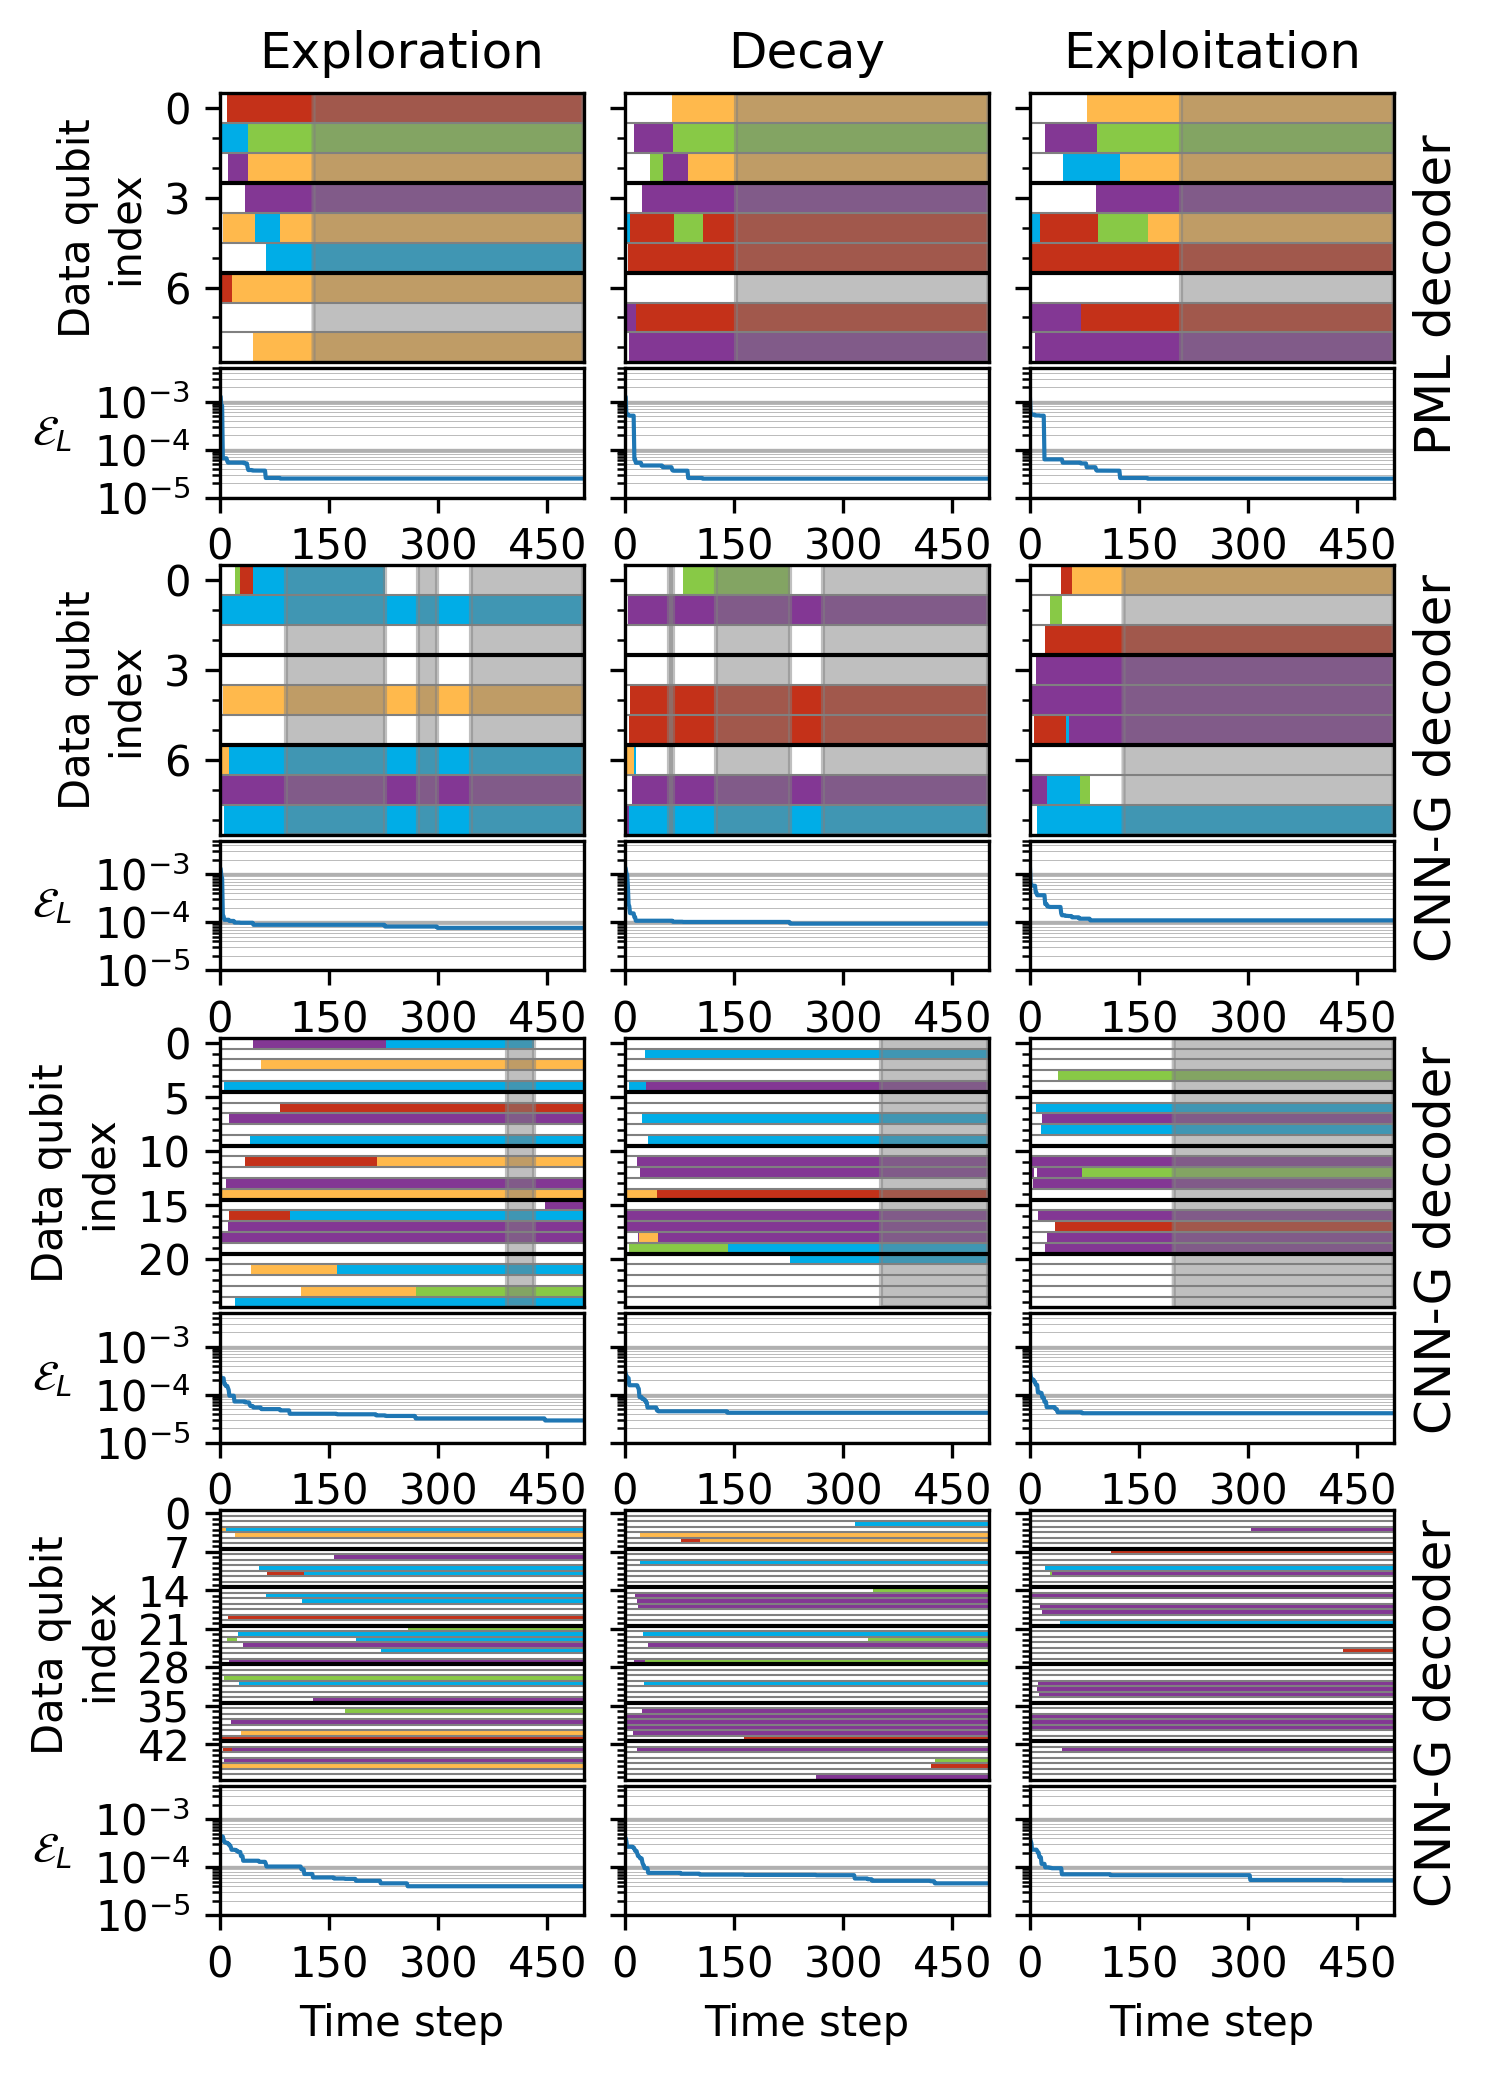

In [ ]:
scaling_names = ["exploration", "decay", "exploitation"]
file_names = [("PML", 3), ("CNN-G", 3), ("CNN-G", 5), ("CNN-G", 7)]

fig = plt.figure(dpi=300, figsize=(1.35,0.9))

xlim = (-.5, 500+.5)
ylim = (1E-5, 5E-3)

for j, (decoder, code_distance) in enumerate(file_names):
    for i, scaling_name in enumerate(scaling_names):
        settings, model_params = load_params(f"data/RL-{decoder}-{code_distance}-{scaling_name}.json")

        scores = settings["scores"]
        deformations = settings["deformations"]
        dones = settings["dones"]

        error_rates: jnp.ndarray = -jnp.log(.99) / scores[:1+int(xlim[-1]-.5)]
        # error_rates: jnp.ndarray = -jnp.log(.99) / scores#[~dones]

        width = .9
        ax1 = fig.add_axes((i,-1.75*j,width,1))
        ax2 = fig.add_axes((i,-.5 - 1.75*j,width,.48))

        if j == 0:
            ax1.set_title(scaling_name.capitalize())

        im_aspect = error_rates.shape[0] / deformations.shape[1]
        fig_aspect = fig.get_figheight() / fig.get_figwidth() / width

        im = ax1.imshow(deformations[:error_rates.shape[0]].T, aspect=im_aspect*fig_aspect, interpolation="nearest", cmap=deformation_cmap, vmin=-.5, vmax=5.5)
        ax1.set_xlim(*xlim)
        ax1.set_xticks([])
        ax1.set_yticks(jnp.arange(0, deformations.shape[1], code_distance))
        ax1.set_yticks(jnp.arange(0, deformations.shape[1]), minor=True)
        ax1.set_yticklabels(jnp.arange(0, deformations.shape[1], code_distance))
        ax1.hlines(jnp.arange(code_distance**2)[1:]-.5, [-1]*(code_distance**2-1), [error_rates.shape[0]]*(code_distance**2-1), color='gray', lw=.5)
        ax1.hlines(code_distance*jnp.arange(code_distance)[1:]-.5, [-1]*(code_distance-1), [error_rates.shape[0]]*(code_distance-1), color='k', lw=1)
        ax1.fill_between(
            range(len(dones)), 
            -0.5, 
            deformations.shape[1] - 0.5, 
            where=dones, 
            color='gray', 
            alpha=0.5, 
            step='mid'
        )

        ax2.plot(range(error_rates.shape[0]), error_rates, '-', lw=1)
        ax2.set_xticks(jnp.arange(0, 550, 150))
        ax2.set_xlim(-.5, error_rates.shape[0]+.5)
        ax2.set_yscale('log')
        ax2.set_ylim(*ylim)
        ax2.set_xlim(*xlim)
        ax2.grid(which='major', axis='y')
        ax2.grid(which='minor', lw=.2)
        # ax2.fill_between(
        #     range(len(dones)), 
        #     -0.5, 
        #     deformations.shape[1] - 0.5, 
        #     where=dones, 
        #     color='gray', 
        #     alpha=0.5, 
        #     step='mid'
        # )

        if i != 0:
            ax1.set_yticklabels([], minor=False)
            ax1.set_yticklabels([], minor=True)
            ax2.set_yticklabels([], minor=False)
            ax2.set_yticklabels([], minor=True)
        else:
            ax1.set_ylabel("Data qubit\nindex")
            ax2.set_ylabel("$\\mathcal{E}_L$", rotation=0, labelpad=10, ha='center', va='center')
        if i == len(scaling_names)-1:
            ax1.annotate(
                f"{decoder} decoder",
                xy=(1.05, 0.25),
                xycoords='axes fraction',
                ha='left',
                va='center',
                fontsize=12,
                rotation=90
            )
        
        if j == len(file_names)-1:
            ax2.set_xlabel("Time step")
        # else:
        #     ax2.set_xticklabels([])

plt.savefig(f"figs/RL-Progress-combined.eps", bbox_inches='tight', dpi=300)
plt.savefig(f"figs/RL-Progress-combined.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"figs/RL-Progress-combined.png", bbox_inches='tight', dpi=300)

plt.show()

In [15]:
scaling_names = ["exploration", "decay", "exploitation"]
file_names = [("PML", 3), ("CNN-G", 3), ("CNN-G", 5), ("CNN-G", 7)]

for j, (decoder, code_distance) in enumerate(file_names):
    code = SurfaceCode(code_distance)
    for i, scaling_name in enumerate(scaling_names):
        settings, model_params = load_params(f"data/RL-{decoder}-{code_distance}-{scaling_name}.json")
        # display(f"data/RL-{decoder}-{code_distance}-{scaling_name}.json")

        deformation = settings["deformations"][-1]

        # parity_information = code.deformation_parity_info(deformation)
        # print(
        #     code.show_latex_code(parity_information, deformation)
        # )

        print(f"DEFORMATION, NAME = jnp.array([{', '.join(str(d) for d in deformation)}], dtype=jnp.int32), \"CNN-S-{code_distance}-RL-{scaling_name}-{decoder}\"")

DEFORMATION, NAME = jnp.array([2, 1, 5, 4, 5, 3, 5, 0, 5], dtype=jnp.int32), "CNN-S-3-RL-exploration-PML"
DEFORMATION, NAME = jnp.array([5, 1, 5, 4, 2, 2, 0, 2, 4], dtype=jnp.int32), "CNN-S-3-RL-decay-PML"
DEFORMATION, NAME = jnp.array([5, 1, 5, 4, 5, 2, 0, 2, 4], dtype=jnp.int32), "CNN-S-3-RL-exploitation-PML"
DEFORMATION, NAME = jnp.array([0, 3, 0, 0, 5, 0, 3, 4, 3], dtype=jnp.int32), "CNN-S-3-RL-exploration-CNN-G"
DEFORMATION, NAME = jnp.array([0, 4, 0, 0, 2, 2, 0, 4, 3], dtype=jnp.int32), "CNN-S-3-RL-decay-CNN-G"
DEFORMATION, NAME = jnp.array([5, 0, 2, 4, 4, 4, 0, 0, 3], dtype=jnp.int32), "CNN-S-3-RL-exploitation-CNN-G"
DEFORMATION, NAME = jnp.array([0, 0, 5, 0, 3, 0, 2, 4, 0, 3, 0, 5, 0, 4, 5, 4, 3, 4, 4, 0, 0, 3, 0, 1, 3], dtype=jnp.int32), "CNN-S-5-RL-exploration-CNN-G"
DEFORMATION, NAME = jnp.array([0, 3, 0, 0, 4, 0, 0, 3, 0, 3, 0, 4, 4, 0, 2, 0, 4, 4, 4, 3, 3, 0, 0, 0, 0], dtype=jnp.int32), "CNN-S-5-RL-decay-CNN-G"
DEFORMATION, NAME = jnp.array([0, 0, 0, 1, 0, 0, 3, 4, 3, 0, 0

In [16]:
for j, (decoder, code_distance) in enumerate(file_names):
    code = SurfaceCode(code_distance)
    for i, scaling_name in enumerate(scaling_names):
        settings, model_params = load_params(f"data/RL-{decoder}-{code_distance}-{scaling_name}.json")
        # display(f"data/RL-{decoder}-{code_distance}-{scaling_name}.json")

        deformation = settings["deformations"][-1]
        
        print(f"(\"CNN-S-{code_distance}-RL-{scaling_name}-{decoder}\", {code_distance}, jnp.array([{', '.join(str(d) for d in deformation)}], dtype=jnp.int32)),")

("CNN-S-3-RL-exploration-PML", 3, jnp.array([2, 1, 5, 4, 5, 3, 5, 0, 5], dtype=jnp.int32)),
("CNN-S-3-RL-decay-PML", 3, jnp.array([5, 1, 5, 4, 2, 2, 0, 2, 4], dtype=jnp.int32)),
("CNN-S-3-RL-exploitation-PML", 3, jnp.array([5, 1, 5, 4, 5, 2, 0, 2, 4], dtype=jnp.int32)),
("CNN-S-3-RL-exploration-CNN-G", 3, jnp.array([0, 3, 0, 0, 5, 0, 3, 4, 3], dtype=jnp.int32)),
("CNN-S-3-RL-decay-CNN-G", 3, jnp.array([0, 4, 0, 0, 2, 2, 0, 4, 3], dtype=jnp.int32)),
("CNN-S-3-RL-exploitation-CNN-G", 3, jnp.array([5, 0, 2, 4, 4, 4, 0, 0, 3], dtype=jnp.int32)),
("CNN-S-5-RL-exploration-CNN-G", 5, jnp.array([0, 0, 5, 0, 3, 0, 2, 4, 0, 3, 0, 5, 0, 4, 5, 4, 3, 4, 4, 0, 0, 3, 0, 1, 3], dtype=jnp.int32)),
("CNN-S-5-RL-decay-CNN-G", 5, jnp.array([0, 3, 0, 0, 4, 0, 0, 3, 0, 3, 0, 4, 4, 0, 2, 0, 4, 4, 4, 3, 3, 0, 0, 0, 0], dtype=jnp.int32)),
("CNN-S-5-RL-exploitation-CNN-G", 5, jnp.array([0, 0, 0, 1, 0, 0, 3, 4, 3, 0, 0, 4, 1, 4, 0, 0, 4, 2, 4, 4, 0, 0, 0, 0, 0], dtype=jnp.int32)),
("CNN-S-7-RL-exploration-CNN-G"